# 기본 설정

In [1]:
import sys
# sklearn ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns
import os
import platform
# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

In [2]:
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [4]:
file_path = 'C:\\Users\\USER\\Documents\\LGhv_practice\\resource\\ml\\data/'

In [5]:
#한글 설정
#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

In [6]:
#음수 표현을 위한 설정
mpl.rcParams['axes.unicode_minus'] = False

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score


# Ensemble

## 투표 기반 분류기

In [10]:
# 데이터 생성
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X[:5], y[:5]

(array([[ 0.83103915, -0.25874875],
        [ 1.18506381,  0.92038714],
        [ 1.16402213, -0.45552558],
        [-0.0236556 ,  1.08628844],
        [ 0.48050273,  1.50942444]]),
 array([1, 0, 1, 0, 0], dtype=int64))

In [12]:
#모델 생성 및 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [13]:
#각 모델의 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


## 간접 투표 방식

In [14]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
#svm은 원래 predict_proba 함수를 사용 할 수 없기 때문에 probability = True 옵션 설정
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [15]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [18]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


## oob

In [19]:
#oob 평가
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

## Bagging & Random Forest

In [20]:
#bagging
bag_clf = BaggingClassifier( DecisionTreeClassifier(max_features="sqrt", 
                                                    max_leaf_nodes=16),
                                                    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [22]:
print(np.sum(y_pred == y_pred_rf) / len(y_pred))

1.0


## titanic data - RandomForest 적용

In [24]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')

#결측치 처리
# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

In [25]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

In [26]:
# 속성(변수) 선택 - feature / target 분리
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male',
'town_C', 'town_Q', 'town_S']] #독립 변수 X
y=ndf['survived'] #종속 변수 Y

In [31]:
# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit(X).transform(X)
X[:5]

array([[ 0.91123237, -0.53037664,  0.52457013, -0.50589515, -0.75905134,
         0.75905134, -0.47180795, -0.20203051,  0.53307848],
       [-1.47636364,  0.57183099,  0.52457013, -0.50589515,  1.31743394,
        -1.31743394,  2.11950647, -0.20203051, -1.87589641],
       [ 0.91123237, -0.25482473, -0.55170307, -0.50589515,  1.31743394,
        -1.31743394, -0.47180795, -0.20203051,  0.53307848],
       [-1.47636364,  0.36516706,  0.52457013, -0.50589515,  1.31743394,
        -1.31743394, -0.47180795, -0.20203051,  0.53307848],
       [ 0.91123237,  0.36516706, -0.55170307, -0.50589515, -0.75905134,
         0.75905134, -0.47180795, -0.20203051,  0.53307848]])

In [29]:
#train data 와 test data로 구분(7:3 비율)
#1. 데이터의 배치가 random한지 아닌지
#데이터가 random 하게 배치되어 있다면 분할을 할 때 부가적인 shuffle 필요 X 
#2. target의 비율
#target의 비율이 고르지 않다면 
#2-1 층화 추출
#2-2 oversampling / undersampling
#이상치 탐지에서 이부분이 항상 고려 대상
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [32]:
#
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=25,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=25, n_jobs=2,
                       random_state=1)

In [33]:
# test data를 가지고 y_hat을 예측 (분류)
y_hat = forest.predict(X_test)
print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]




In [34]:
# 모형 성능 평가 - Confusion Matrix 계산
#오차 행렬 계산
from sklearn import metrics
tree_matrix = metrics.confusion_matrix(y_test, y_hat)
print(tree_matrix)
print('\n')

#정확도 계산
print((tree_matrix[0,0] + tree_matrix[1,1]) / np.sum(tree_matrix))

[[106  19]
 [ 27  63]]




In [35]:
# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)
print(tree_report)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       125
           1       0.77      0.70      0.73        90

    accuracy                           0.79       215
   macro avg       0.78      0.77      0.78       215
weighted avg       0.78      0.79      0.78       215



(-1.0, 9.0)

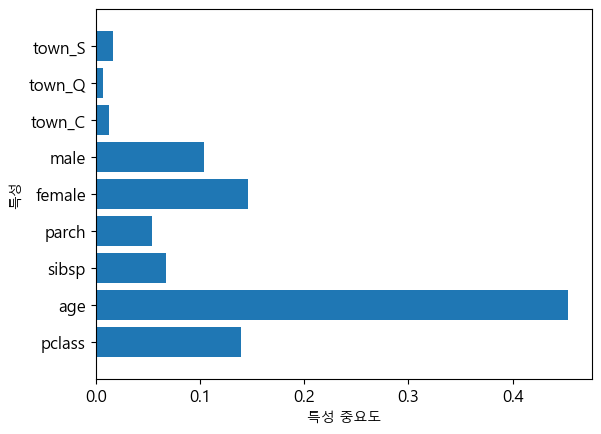

In [36]:
#특성 중요도
n_features = X.data.shape[1]
plt.barh(np.arange(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male',
                                   'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)

## Ada Boost

In [38]:
from sklearn.ensemble import AdaBoostClassifier

#algorithm은 확률을 계산 할 수 있으며 
#
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                             algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_hat = ada_clf.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 0 1 0 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]


In [39]:
# 모형 성능 평가 - Confusion Matrix 계산
#오차 행렬 계산
ada_matrix = metrics.confusion_matrix(y_test, y_hat)
print(ada_matrix)
print('\n')

#정확도 계산
print((ada_matrix[0,0] + ada_matrix[1,1]) / np.sum(ada_matrix))

ada_report = metrics.classification_report(y_test, y_hat)
print(ada_report)

[[105  20]
 [ 20  70]]


0.813953488372093
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       125
           1       0.78      0.78      0.78        90

    accuracy                           0.81       215
   macro avg       0.81      0.81      0.81       215
weighted avg       0.81      0.81      0.81       215



## Gradient Boosting

In [43]:
%%time
#jupyter notebook에서 시간 측정할 때 사용 
from sklearn.ensemble import GradientBoostingClassifier

#algorithm은 확률을 계산 할 수 있으며 
#
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

y_hat = gb_clf.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]
CPU times: total: 62.5 ms
Wall time: 70.7 ms


## hyper parameter tuning

In [44]:
# 하이퍼 파라미터 및 튜닝
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 100}
최고 예측 정확도: 0.7896


In [47]:
#예측을 수행하고 정확도 확인
#GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행.
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

gb_report = metrics.classification_report(y_test, gb_pred)
print(gb_report)

GBM 정확도: 0.8372
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       125
           1       0.89      0.70      0.78        90

    accuracy                           0.84       215
   macro avg       0.85      0.82      0.83       215
weighted avg       0.84      0.84      0.83       215



## XGBoost

In [9]:
!conda install -c anaconda py-xgboost
#!pip install xgboost

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.3

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.3




In [15]:
    import xgboost as xgb
    from sklearn.datasets import load_breast_cancer

    dataset = load_breast_cancer()

    X_features = dataset.data
    y_label = dataset.target

    cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
    cancer_df['target'] = y_label
    cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [16]:
#data 분포 확인 - 이 비율이 한 쪽으로 치우치면 가중치 적용 / 층화추출 고민
cancer_df.target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [20]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
test_size=0.2, random_state=42 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


In [21]:
#xgboost를 이용하는 경우의 데이터 생성
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [23]:
#hyper paramter
params = { 'max_depth':3,
          'eta': 0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
}
num_rounds = 400

#훈련 데이터와 검증 데이터 생성
wlist = [(dtrain, 'train'), (dtest, 'eval')]

#모델 생성
xgb_model = xgb.train(params = params, dtrain = dtrain, 
                      num_boost_round = num_rounds,
                      early_stopping_rounds = 100,
                      evals = wlist)

[0]	train-logloss:0.60961	eval-logloss:0.61443
[1]	train-logloss:0.54076	eval-logloss:0.54721
[2]	train-logloss:0.48407	eval-logloss:0.49559
[3]	train-logloss:0.43324	eval-logloss:0.44659
[4]	train-logloss:0.38985	eval-logloss:0.40682
[5]	train-logloss:0.35212	eval-logloss:0.37082
[6]	train-logloss:0.31949	eval-logloss:0.34032
[7]	train-logloss:0.29139	eval-logloss:0.31559
[8]	train-logloss:0.26606	eval-logloss:0.29181
[9]	train-logloss:0.24392	eval-logloss:0.27323
[10]	train-logloss:0.22408	eval-logloss:0.25490
[11]	train-logloss:0.20697	eval-logloss:0.24217
[12]	train-logloss:0.19128	eval-logloss:0.22577
[13]	train-logloss:0.17705	eval-logloss:0.21283
[14]	train-logloss:0.16451	eval-logloss:0.19947
[15]	train-logloss:0.15319	eval-logloss:0.19169
[16]	train-logloss:0.14312	eval-logloss:0.18069
[17]	train-logloss:0.13410	eval-logloss:0.17432
[18]	train-logloss:0.12522	eval-logloss:0.16573
[19]	train-logloss:0.11687	eval-logloss:0.15517
[20]	train-logloss:0.10980	eval-logloss:0.15131
[2

In [24]:
#예측
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

#확률을 가지고 실제 class 예측
# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.995 0.    0.    1.    1.    0.    0.001 0.065 0.346 1.   ]
예측값 10개만 표시: [1, 0, 0, 1, 1, 0, 0, 0, 0, 1]


In [26]:
#평가 지표 확인
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    #정확도
    accuracy = accuracy_score(y_test , pred)
    #정밀도 - True로 판정한 것 중에서 실제로 True인 비율: 잘못 검색되면 안되는 경우 중요
    precision = precision_score(y_test , pred)
    #재현율 - 실제로 True인 것 중에서 True로 판정한 비율: 정보 검색에서 중요
    recall = recall_score(y_test , pred)
    #f1 score: 정밀도와 재현율의 조화 평균 - 데이터가 불균형 할 때 중요
    f1 = f1_score(y_test,pred)
    # ROC-AUC - 1에 가까울 수록 좋은 수치
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[41  2]
 [ 1 70]]
정확도: 0.9737, 정밀도: 0.9722, 재현율: 0.9859,    F1: 0.9790, AUC:0.9941


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

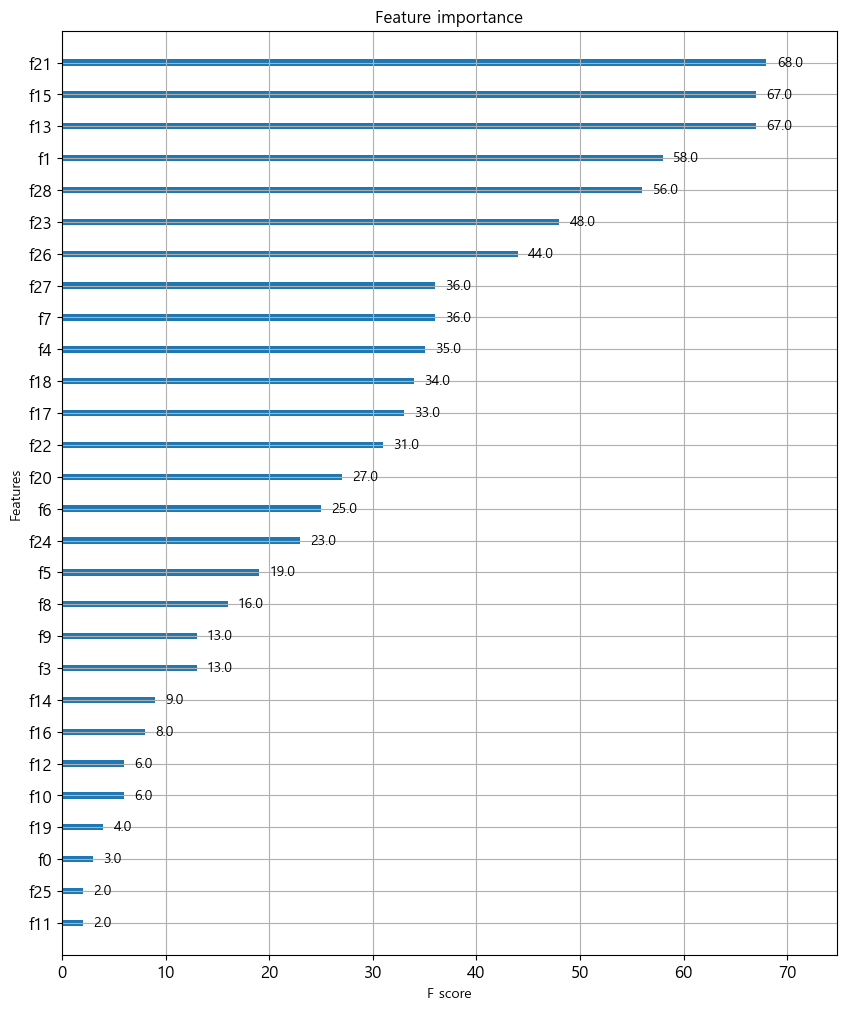

In [27]:
#feature importance = 피처 중요도 확인
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

## Light GBM

In [31]:
from lightgbm import LGBMClassifier

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2,
random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
eval_set=evals, verbose=True)


[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

c:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\USER\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(n_estimators=400)

In [32]:
#예측 수행
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

print(preds[:10])
print(pred_proba[:10])

[1 0 1 0 1 1 1 1 1 0]
[0.60514473 0.00747978 0.94351324 0.14309567 0.97666949 0.99589589
 0.99463733 0.99033792 0.99349033 0.00654626]


In [30]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,    F1: 0.9682, AUC:0.9905


# stacking

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score


In [37]:
cancer_data = load_breast_cancer()
X_data = cancer_data.data
y_label = cancer_data.target
X_train , X_test , y_train , y_test = train_test_split(X_data , y_label ,
test_size=0.2 , random_state=0)

In [38]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성.
lr_final = LogisticRegression(C=10)

In [39]:
# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [42]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트을 생성하고 개별 모델의 정확도 측정.
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('Random Forest 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} '.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
Random Forest 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 


In [46]:
#모델이 예측한 결과를 가지고 새로운 데이터 생성
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [45]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
    
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)

        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)

        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [51]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


In [52]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
'스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [53]:
#결과를 가지고 다시 훈련
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
